In [3]:
import os
from typing import Tuple, List, Iterable, Callable

import math
import time
import numpy as np
import pandas as pd
from scipy.stats import halfcauchy, invgamma
import cvxpy as cp
from matplotlib import pyplot as plt
from scipy import stats

from scipy.stats import multivariate_normal
from numpy.random import default_rng
from itertools import chain, combinations, product

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)

## Sources

#### BOCS

Baptista, Poloczek (2018) - Bayesian Optimization of Combinatorial Structures

##### Sparse Bayesian Regression
Makalic, Schmidt (2015) - A simple sampler for the horseshoe estimator [Link](https://arxiv.org/pdf/1508.03884.pdf)

## 1. Define Trivial binary function 

$$ g: \mathcal{D} \longrightarrow \mathbb{R} $$
    
where $\mathcal{D}$ is a combinatorial domain (e.g. a set of graphs or molecule structrues). Let $\mathcal{D} = \{1,2,...,d \}$. 

For some $\delta \in \mathcal{D}$, $g(\delta)$ describes the scalar-valued property of graph (e.g. overall utility of a network of bike stations or the solubility of a drug-like molecule).

We model $f$ as affine-linear in presence of each of the $2^{|\mathcal{D}|}$ possible components in $\mathcal{D}$. In particular, let the dummy variable $x_{i}$ describe if a component is present in the combinatorial structure (e.g. a node in a graph or an element in a molecule). In particular, $x_{i} = \mathbb{1}\{ \delta_{i} \in \delta \}$. Restrict to interactions up to order $2$.

$$ f_{\boldsymbol{\alpha}} = \alpha_{0} + \sum_{j=1}^{d} \alpha_{j} x_{j} + \sum_{i<j}^{d} \alpha_{ij}x_{i}x_{j} $$

with $\boldsymbol{\alpha} = (\alpha_{i}, \alpha_{ij}) \in \mathbb{R}^{p}$, $\alpha_{i} \in \mathbb{R}$ and $p=1+d+\binom{d}{k}$.

Let a sample function $f_{1} = \sum \limits_{k \in 2^{|\mathcal{D}|}} \prod \limits_{i=1}^{d} \alpha_{k_{i}} x_{i}$ to be continued.

In [4]:
def powerset(x:Iterable):
    '''
    Powerset (set of subsets) for a given iterable x incl. ∅
    '''
    s = list(x)
    powerSet = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    
    return list(powerSet)

def gDict(d:int, k:int, seed:int=3256, eTol:float=10E-2) -> dict:
    '''
    Black-box function for combinatorial optimization (example model problem)
    x    : input tuple   
    d    : dimension |D|
    k    : order of polynomials w/ significant (from 0) coefficients
    seed : seed for generation of random coefficients
    '''
    
    # a : compute groundtruth coefficients
    k_sig = sum([math.comb(d,i) for i in range(k+1)])
    np.random.seed(seed)
    a = np.random.normal(size=2**d, loc=0, scale=7)
    #a[k_sig:] = np.random.normal(size=len(a[k_sig:]), loc=0, scale=eTol) # reduce order of magnitude by factor of 10 for non-sifnificant orders
    a = a.round(4)
    
    a[k_sig:] = 0
    
    # dict
    g_of_x_dict = {k:v for k,v in zip(powerset(range(d)), a)}
    
    # g(x)
    return g_of_x_dict, a

def g(x:Iterable, g_dict:dict) -> float:
    '''
    Compute g(x) given x and d dictionary
    '''
    # binary to index
    x = [i for i,x_i in enumerate(x) if x_i==1]
    powSet = powerset(x)
    
    #print(f'x: {x},\npowSet: {powSet}\nmatch-len:', len(([g_dict[x_i] for x_i in powSet if x_i in g_dict])), '\n g(x):', sum([g_dict[x_i] for x_i in powSet if x_i in g_dict]))
    #print()
    
    return sum([g_dict[x_i] for x_i in powSet if x_i in g_dict])

def getX(n:int, d:int, k:int, prob:float=0.4, seed:int=3256) -> np.array:
    '''
    X ∈ R^{n x p}
    p: column order (derived from 1 (intercept.) + d (dim. of input) + (d over 2) + ... (d over k))
    '''
    # 
    if(k==0):
        return np.ones((n,1))
    
    # generate column-values {1,...d}
    X = np.random.binomial(n=1, p=prob, size=n*d).reshape((n,d))
    
    #print("X.shape: ", X.shape)
    
    # extend to canonical form (intercept, 1,...,d, 2nd order terms, 3rd order terms etc.)
    p = sum([math.comb(d,i) for i in range(k+1)])
    X_can = np.zeros((n,p))
    #print("X_can.shape: ", X_can.shape)
    pSet = powerset(range(d))
    for i,Xrow in enumerate(X):
        x_repr = [i for i,x_i in enumerate(Xrow) if x_i==1]
        X_can[i,:] = np.array([1 if (x in powerset(x_repr)) else 0 for x in pSet[:p]])
    # rename
    X = X_can
    
    # intercept column
    X[:,0] = 1 
    
    return X

def getY(X:np.array, d:int, g_dict:dict, errorFlag:bool=False, sigma:float=0.1) -> np.array:
    '''
    Compute function value y given black-box function g and binary input matrix of dimemension 
    '''
    y = np.zeros(len(X))
    
    # populate
    for i,xRow_i in enumerate(X):
        y[i] = g(xRow_i[1:1+d], g_dict=g_dict)
        
    # additive Gaussian error
    if(errorFlag):
        print('Flag, min()=', min(y))
        y += np.random.normal(size=len(y), loc=0, scale=sigma)
    
    return y

In [5]:
# parameters
n, d, k = 500, 12, 2

# generate dataset
gD, a_GT = gDict(d=d, k=k, seed=553)

X = getX(n=n, d=d, k=k, seed=1224)
y = getY(X, d=d, g_dict=gD, errorFlag=True, sigma=0.2)

#X_tr
min(y)

Flag, min()= -42.6183


-42.70470800205029

## 1 Sampling Basics: Parametrize the Inverse Gamme Distributions properly
Inverse Gamma distribution simulatin
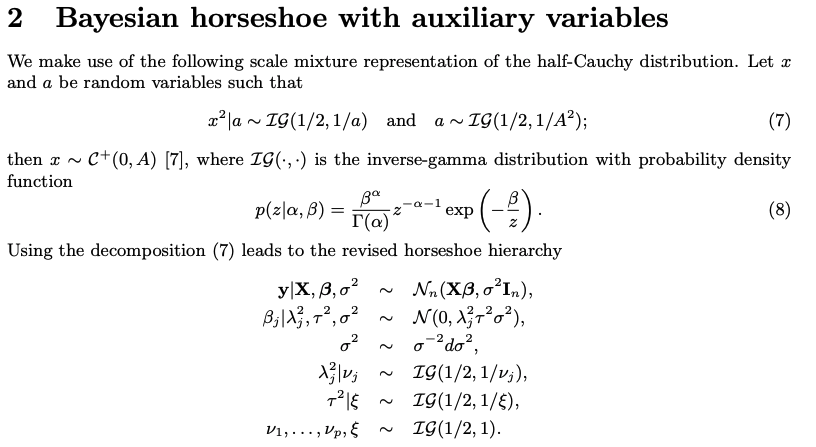

In [6]:
def bhs(Xorg, yorg, nsamples, burnin, thin):
    # Implementation of the Bayesian horseshoe linear regression hierarchy.
    # Parameters:
    #   Xorg     = regressor matrix [n x p]
    #   yorg     = response vector  [n x 1]
    #   nsamples = number of samples for the Gibbs sampler (nsamples > 0)
    #   burnin   = number of burnin (burnin >= 0)
    #   thin     = thinning (thin >= 1)
    #
    # Returns:
    #   beta     = regression parameters  [p x nsamples]
    #   b0       = regression param. for constant [1 x nsamples]
    #   s2       = noise variance sigma^2 [1 x nsamples]
    #   t2       = hypervariance tau^2    [1 x nsamples]
    #   l2       = hypervariance lambda^2 [p x nsamples]
    #  
    #
    # Example:
    # % Load a dataset:
    # load hald;        
    # % Run horseshoe sampler. Normalising the data is not required.
    # [beta, b0] = bhs(ingredients, heat, 1000, 100, 10);    
    # % Plot the samples of the regression coefficients:
    # boxplot(beta', 'labels', {'tricalcium aluminate','tricalcium silicate',...
    #   'tetracalcium aluminoferrite', 'beta-dicalcium silicate'});
    # title('Bayesian linear regression with the horseshoe hierarchy');
    # xlabel('Predictors');
    # ylabel('Beta');
    # grid;
    #
    #
    # References:
    # A simple sampler for the horseshoe estimator
    # E. Makalic and D. F. Schmidt
    # arXiv:1508.03884, 2015
    #
    # The horseshoe estimator for sparse signals
    # C. M. Carvalho, N. G. Polson and J. G. Scott
    # Biometrika, Vol. 97, No. 2, pp. 465--480, 2010
    #
    # (c) Copyright Enes Makalic and Daniel F. Schmidt, 2015
    # Adapted to python by Ricardo Baptista, 2018

    n, p = Xorg.shape

    # Normalize data
    X, _, _, y, muY = standardise(Xorg, yorg)

    # Return values
    beta = np.zeros((p, nsamples))
    s2 = np.zeros((1, nsamples))
    t2 = np.zeros((1, nsamples))
    l2 = np.zeros((p, nsamples))

    # Initial values
    sigma2  = 1.
    lambda2 = np.random.uniform(size=p)
    tau2    = 1.
    nu      = np.ones(p)
    xi      = 1.

    # pre-compute X'*X (used with fastmvg_rue)
    XtX = np.matmul(X.T,X)  

    # Gibbs sampler
    k = 0
    iter = 0
    while(k < nsamples):

        # Sample from the conditional posterior distribution
        sigma = np.sqrt(sigma2)
        Lambda_star = tau2 * np.diag(lambda2)
        # Determine best sampler for conditional posterior of beta's
        if (p > n) and (p > 200):
            b = fastmvg(X/sigma, y/sigma, sigma2*Lambda_star)
        else:
            b = fastmvg_rue(X/sigma, XtX/sigma2, y/sigma, sigma2*Lambda_star)

        # Sample sigma2
        e = y - np.dot(X,b)
        shape = (n + p) / 2.
        scale = np.dot(e.T,e)/2. + np.sum(b**2/lambda2)/tau2/2.
        sigma2 = 1. / np.random.gamma(shape, 1./scale)

        # Sample lambda2
        scale = 1./nu + b**2./2./tau2/sigma2
        lambda2 = 1. / np.random.exponential(1./scale)

        # Sample tau2
        shape = (p + 1.)/2.
        scale = 1./xi + np.sum(b**2./lambda2)/2./sigma2
        tau2 = 1. / np.random.gamma(shape, 1./scale)

        # Sample nu
        scale = 1. + 1./lambda2
        nu = 1. / np.random.exponential(1./scale)

        # Sample xi
        scale = 1. + 1./tau2
        xi = 1. / np.random.exponential(1./scale)

        # Store samples
        iter = iter + 1;
        if iter > burnin:
            # thinning
            if (iter % thin) == 0:
                beta[:,k] = b
                s2[:,k]   = sigma2
                t2[:,k]   = tau2
                l2[:,k]   = lambda2
                k         = k + 1

    # Re-scale coefficients
    #div_vector = np.vectorize(np.divide)
    #beta = div_vector(beta.T, normX)
    #b0 = muY-np.dot(muX,beta)
    b0 = muY

    return (beta, b0, s2, t2, l2)

def fastmvg(Phi, alpha, D):
    # Fast sampler for multivariate Gaussian distributions (large p, p > n) of 
    #  the form N(mu, S), where
    #       mu = S Phi' y
    #       S  = inv(Phi'Phi + inv(D))
    # Reference: 
    #   Fast sampling with Gaussian scale-mixture priors in high-dimensional 
    #   regression, A. Bhattacharya, A. Chakraborty and B. K. Mallick
    #   arXiv:1506.04778

    n, p = Phi.shape

    d = np.diag(D)
    u = np.random.randn(p) * np.sqrt(d)
    delta = np.random.randn(n)
    v = np.dot(Phi,u) + delta
    #w = np.linalg.solve(np.matmul(np.matmul(Phi,D),Phi.T) + np.eye(n), alpha - v)
    #x = u + np.dot(D,np.dot(Phi.T,w))
    mult_vector = np.vectorize(np.multiply)
    Dpt = mult_vector(Phi.T, d[:,np.newaxis])
    w = np.linalg.solve(np.matmul(Phi,Dpt) + np.eye(n), alpha - v)
    x = u + np.dot(Dpt,w)

    return x

def fastmvg_rue(Phi, PtP, alpha, D):
    # Another sampler for multivariate Gaussians (small p) of the form
    #  N(mu, S), where
    #  mu = S Phi' y
    #  S  = inv(Phi'Phi + inv(D))
    #
    # Here, PtP = Phi'*Phi (X'X is precomputed)
    #
    # Reference:
    #   Rue, H. (2001). Fast sampling of gaussian markov random fields. Journal
    #   of the Royal Statistical Society: Series B (Statistical Methodology) 
    #   63, 325-338

    p = Phi.shape[1]
    Dinv = np.diag(1./np.diag(D))

    # regularize PtP + Dinv matrix for small negative eigenvalues
    try:
        L = np.linalg.cholesky(PtP + Dinv)
    except:
        mat  = PtP + Dinv
        Smat = (mat + mat.T)/2.
        maxEig_Smat = np.max(np.linalg.eigvals(Smat))
        L = np.linalg.cholesky(Smat + maxEig_Smat*1e-15*np.eye(Smat.shape[0]))

    v = np.linalg.solve(L, np.dot(Phi.T,alpha))
    m = np.linalg.solve(L.T, v)
    w = np.linalg.solve(L.T, np.random.randn(p))

    x = m + w

    return x

def standardise(X, y):
    # Standardize the covariates to have zero mean and x_i'x_i = 1

    # set params
    n = X.shape[0]
    meanX = np.mean(X, axis=0)
    stdX  = np.std(X, axis=0) * np.sqrt(n)

    # Standardize X's
    #sub_vector = np.vectorize(np.subtract)
    #X = sub_vector(X, meanX)
    #div_vector = np.vectorize(np.divide)
    #X = div_vector(X, stdX)

    # Standardize y's
    meany = np.mean(y)
    y = y - meany

    return (X, meanX, stdX, y, meany)

In [7]:
# - - - - - - -  
#  DATA
# - - - - - - - 
n = 100

# generate dataset
gD, a_GT = gDict(d=d, k=k)

X = getX(n=n, d=d, k=k)
y = getY(X, d=d, g_dict=gD, errorFlag=True, sigma=1.0)

#bhs(Xorg, yorg, nsamples, burnin, thin):
(beta, b0, s2, t2, l2) = bhs(Xorg=X, yorg=y, nsamples=1000, burnin=100, thin=4)

Flag, min()= -65.9476


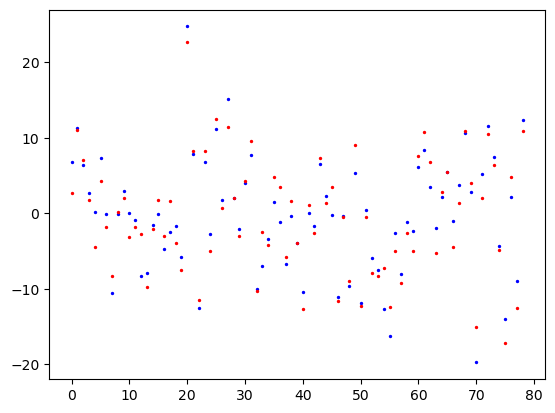

In [8]:
k_target = 100-1
plt.scatter(range(len(beta[:,k_target])), beta[:,k_target], c='blue', alpha=1, s=2)
plt.scatter(range(len(beta[:,k_target])), a_GT[:79], c='red', alpha=1, s=2)
plt.show()

In [9]:
#beta[:,-1]
np.linalg.norm(a_GT[:79] - np.mean(beta,axis=1), ord=2)

12.051659131505321

## Sparse Bayesian Linear Regression

In [10]:
%%time 

N = 100

# para
A = 3
a = invgamma.rvs(0.5, scale=1./(A**2), size=N)

# dataset 1
dset1 = invgamma.rvs(0.5 * np.ones(len(a)), scale=1./a, size=N)
dset1 = np.sqrt(dset1)

# dset 2
dset2 = halfcauchy.rvs(loc=0, scale=A, size=N)


# Compare
print(round(np.quantile(dset1, 0.25), 3), '\t', round(np.quantile(dset1, 0.5), 3), '\t', round(np.quantile(dset1, 0.75), 3))
print(round(np.quantile(dset2, 0.25), 3), '\t', round(np.quantile(dset2, 0.5), 3), '\t', round(np.quantile(dset2, 0.75), 3))


1.573 	 3.614 	 9.35
1.158 	 3.36 	 5.723
CPU times: user 4.9 ms, sys: 2.31 ms, total: 7.21 ms
Wall time: 5.28 ms


## 2. Sparse Bayesian Regression 

#### Re-factor code from `bhs.py`

## P1 : Statistical Model
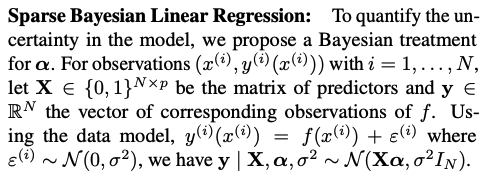

## P2 : Prior Distribution
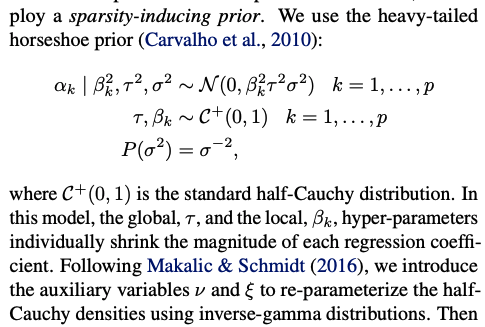

## P3 : Posterior Distribution
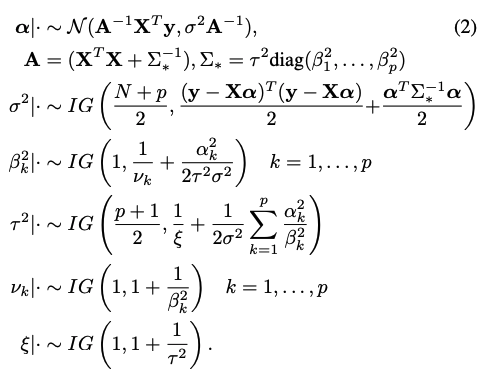

In [ ]:
# p
# parameters
p = sum([math.comb(d,i) for i in range(k+1)])

# - - - - - 
#  PRIOR
# - - - - - 
# sigma
sigma_2_prior = 1.0 # (?)

# tau, beta: C+(0,1)
tau_prior, beta_prior = halfcauchy.rvs(size=1), halfcauchy.rvs(size=p)

# alpha_prior
alpha_prior = np.random.multivariate_normal(mean = np.zeros(p), 
                                            cov  = np.diag(tau_prior**2 * sigma_2_prior * beta_prior**2), 
                                            size = 1).reshape(-1)

#alpha_prior = np.zeros_like(a_GT)
#alpha_prior = a_GT[:len(alpha_prior)]

plt.scatter(range(len(alpha_prior)), alpha_prior, c='grey', alpha=1, s=2)
plt.show()

In [ ]:
# - - - - - - -  
#  DATA
# - - - - - - - 
n = 1000

# generate dataset
gD, a_GT = gDict(d=d, k=k)

X = getX(n=n, d=d, k=k)

#X = np.unique(X, axis=0)

y = getY(X, d=d, g_dict=gD, errorFlag=True, sigma=1.5)

# - - - - - 
#  PRIOR
# - - - - - 
# sigma
sigma_2_prior = 1.0 # (?)

# tau, beta: C+(0,1)
tau_prior, beta_prior = halfcauchy.rvs(size=1), halfcauchy.rvs(size=p)

# alpha_prior
alpha_prior = np.random.multivariate_normal(mean = np.zeros(p), 
                                            cov  = np.diag(tau_prior**2 * sigma_2_prior * beta_prior**2), 
                                            size = 1).reshape(-1)

# - - - - - - -  
#  POSTERIOR
# - - - - - - - 

# xi
xi_post = invgamma.rvs(1.0, scale=1.0 + 1.0 / tau_prior**2, size=1)

# nu
nu_post = invgamma.rvs(np.ones(p), scale=1.0 + beta_prior**(-2), size=len(beta_prior))

# tau
tau_2_post = invgamma.rvs(0.5*(p+1), scale=1.0 / xi_post + (1. / (2. * sigma_2_prior)) * sum(alpha_prior**2 / beta_prior**2), size=1)

# beta
beta_2_post = invgamma.rvs(np.ones(p), scale=(1. / nu_post) + (alpha_prior**2)/(2 * sigma_2_prior * tau_2_post))

# Cov star
Cov_star     = tau_2_post * np.diag(beta_2_post)
Cov_star_inv = np.linalg.inv(Cov_star)

# sigma
sigma_2_post = invgamma.rvs(0.5*(n+p), scale=0.5*(np.linalg.norm((y - X@alpha_prior), 2)**2 + (alpha_prior.T @ Cov_star_inv @ alpha_prior)))

# A
A     = (X.T @ X) + Cov_star_inv
A_inv = np.linalg.inv(A)

# alpha_post
alpha_post = np.random.multivariate_normal(mean = A_inv @ X.T @ y, 
                                           cov  = sigma_2_post * A_inv,
                                           size = 1).reshape(-1)


In [ ]:
lm1 = LinearRegression().fit(X,y)
np.sqrt(mean_squared_error(y_pred=lm1.predict(X), y_true=y))

In [ ]:
plt.plot(alpha_prior)
plt.plot(alpha_post)
plt.ylim((-28, 28))
plt.show()

In [ ]:
print('MSE, Priori')
np.sqrt(mean_squared_error(y_pred=(X @ alpha_prior), y_true=y))

In [ ]:
print('MSE, Posteriori')
np.sqrt(mean_squared_error(y_pred=(X @ alpha_post), y_true=y))

In [ ]:
print('MSE, naïve')
np.sqrt(mean_squared_error(y_pred=[np.mean(y)]*len(y), y_true=y))

In [ ]:
print('MSE, Groundtruth')
np.sqrt(mean_squared_error(y_pred=(X @ a_GT[:X.shape[1]]), y_true=y))

In [ ]:
plt.scatter(range(70), a_GT[:70])
plt.scatter(range(70), alpha_prior[:70], c='red')
plt.ylim((-30,30))
plt.show()

In [ ]:
plt.scatter(range(70), a_GT[:70])
plt.scatter(range(70), alpha_post[:70], c='red')
plt.ylim((-30,30))
plt.show()

## (3.) Acquisition Function

### P1
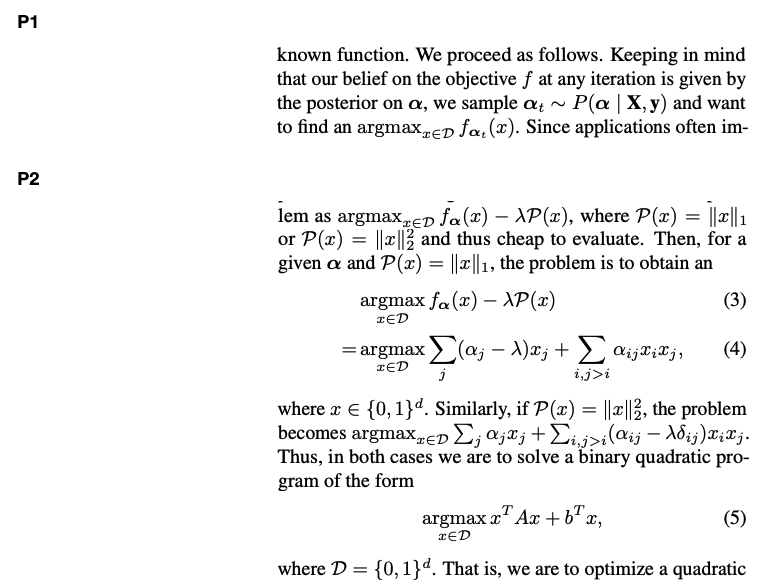


In [11]:
# Optimization
lamb  = 1.1
alpha = alpha_post

# norm
P_x = np.linalg.norm(x=np.array([1,2,-3]), ord=1)
P_x

# split alpha into 1st, 2nd order terms
alpha_1 = alpha[1:1+d]
alpha_2 = alpha[1+d:]

# A: upper triangular matrix of 2nd order coefficients
A = np.zeros((d,d))
A[np.triu_indices(d, k=1)] = alpha_2

# b
b = alpha_1 - lamb*np.ones_like(alpha_1)

# 
np.random.seed(55)
x = np.random.binomial(n=1, p=0.5, size=d)

# output
x.T @ A @ x + b @ x

NameError: name 'alpha_post' is not defined

## (3.) Acquisition Function

### P3
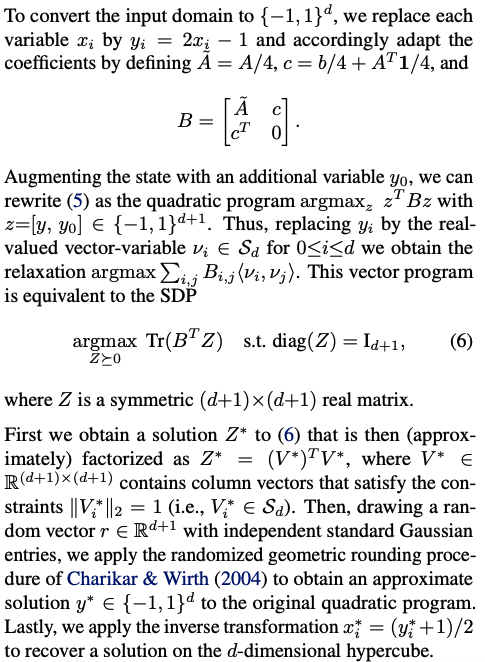


In [ ]:
# DEBUGGED


# Extract vector of coefficients
#b = alpha[1:n_vars+1] + inputs['lambda']
#a = alpha[n_vars+1:]

# 
b = alpha[1:1+d]
a = alpha[1+d:]

# get indices for quadratic terms
idx_prod = np.array(list(combinations(np.arange(d), 2)))
d_idx = idx_prod.shape[0]

# check number of coefficients
if a.size != d_idx:
    raise ValueError('Number of Coefficients does not match indices!')

# Convert a to matrix form
A = np.zeros((d,d))
for i in range(d_idx):
    A[idx_prod[i,0],idx_prod[i,1]] = a[i]/2.
    A[idx_prod[i,1],idx_prod[i,0]] = a[i]/2.

# Convert to standard form
bt = b/2. + np.dot(A, np.ones(d))/2.
bt = bt.reshape((d, 1))
At = np.vstack((np.append(A/4., bt/2.,axis=1),np.append(bt.T,2.)))





# Run SDP relaxation
X = cp.Variable((d+1, d+1), PSD=True)
obj = cp.Minimize(cp.trace(cp.matmul(At,X)))
constraints = [cp.diag(X) == np.ones(d+1)]
prob = cp.Problem(obj, constraints)
prob.solve()

# Extract vectors and compute Cholesky
# add small identity matrix is X.value is numerically not PSD
try:
    L = np.linalg.cholesky(X.value)
except:
    XpI = X.value + 1e-4*np.eye(d+1)
    L = np.linalg.cholesky(XpI)

# Repeat rounding for different vectors
d_rand_vector = 100

model_vect = np.zeros((d, d_rand_vector))
obj_vect   = np.zeros(d_rand_vector)



for kk in range(d_rand_vector):
    # Generate a random cutting plane vector (uniformly 
    # distributed on the unit sphere - normalized vector)
    r = np.random.randn(d+1)
    r = r/np.linalg.norm(r)
    y_soln = np.sign(np.dot(L.T,r))

    # convert solution to original domain and assign to output vector
    model_vect[:,kk] = (y_soln[:d]+1.)/2.
    obj_vect[kk] = np.dot(np.dot(model_vect[:,kk].T,A), model_vect[:,kk])+ np.dot(b, model_vect[:,kk])

    # Find optimal rounded solution
    opt_idx = np.argmin(obj_vect)
    model = model_vect[:,opt_idx]
    obj   = obj_vect[opt_idx]
    
    
# BQP -> SDP
A_tilde = 0.25 * A
c = 0.25 * (b + A.T @ np.ones(d))

B = np.concatenate((A_tilde, c.reshape(d,1)), axis=1)
B = np.concatenate((B, np.pad(c, (0,1)).reshape(1,d+1)), axis=0)

In [ ]:
# Run SDP relaxation
X = cp.Variable((d+1, d+1), PSD=True)
obj = cp.Minimize(cp.trace(cp.matmul(At,X)))
constraints = [cp.diag(X) == np.ones(d+1)]
prob = cp.Problem(obj, constraints)
prob.solve()

# Extract vectors and compute Cholesky
# add small identity matrix is X.value is numerically not PSD
try:
    L = np.linalg.cholesky(X.value)
except:
    XpI = X.value + 1e-4*np.eye(d+1)
    L = np.linalg.cholesky(XpI)

# Repeat rounding for different vectors
d_rand_vector = 100

model_vect = np.zeros((d, d_rand_vector))
obj_vect   = np.zeros(d_rand_vector)


In [ ]:
for kk in range(d_rand_vector):
    # Generate a random cutting plane vector (uniformly 
    # distributed on the unit sphere - normalized vector)
    r = np.random.randn(d+1)
    r = r/np.linalg.norm(r)
    y_soln = np.sign(np.dot(L.T,r))

    # convert solution to original domain and assign to output vector
    model_vect[:,kk] = (y_soln[:d]+1.)/2.
    obj_vect[kk] = np.dot(np.dot(model_vect[:,kk].T,A), model_vect[:,kk])+ np.dot(b, model_vect[:,kk])

    # Find optimal rounded solution
    opt_idx = np.argmin(obj_vect)
    model = model_vect[:,opt_idx]
    obj   = obj_vect[opt_idx]

In [ ]:
# BQP -> SDP
A_tilde = 0.25 * A
c = 0.25 * (b + A.T @ np.ones(d))

B = np.concatenate((A_tilde, c.reshape(d,1)), axis=1)
B = np.concatenate((B, np.pad(c, (0,1)).reshape(1,d+1)), axis=0)

### Semidefinite Program (SDP)

See Code in [link](https://www.cvxpy.org/examples/basic/sdp.html)
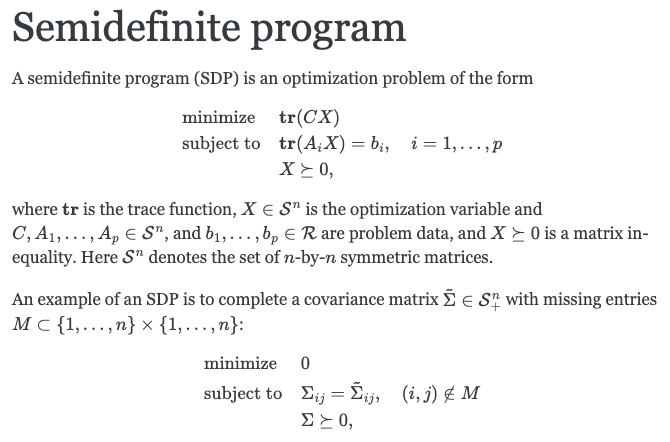

In the Paper
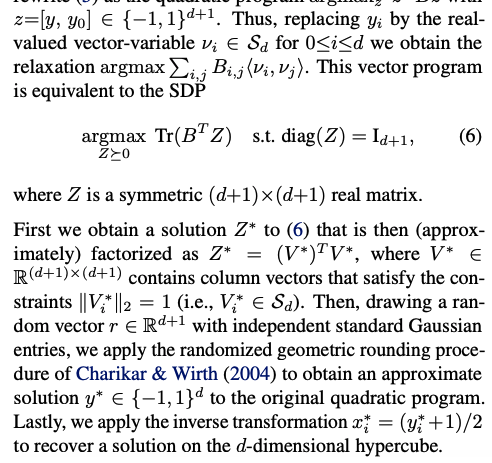

In [ ]:
# Semidefinite Program (SDP) Optimization

# - Z: decision variable (matrix)
Z = cp.Variable((d+1,d+1), PSD=True)

# - constraints
#constr  = [Z >> 0]
constr  = [cp.diag(Z) == np.ones(d+1)]

# - objective
SDP = cp.Problem(cp.Minimize(cp.trace(cp.matmul(B.T, Z))), constr)

# - solve
SDP.solve()

Z_star = Z.value

# - show result
print(f"The optimal value of the SDP: {SDP.value:.2f}")
print(f"\nSolution Z_star: \n{Z_star.round(1)}")

### Stochastic Rounding

See source [here](https://courses.cs.washington.edu/courses/cse522/05au/charikargrothendieck.pdf)

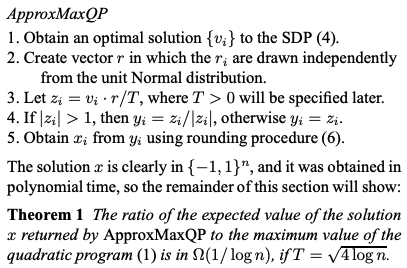

### Rounding

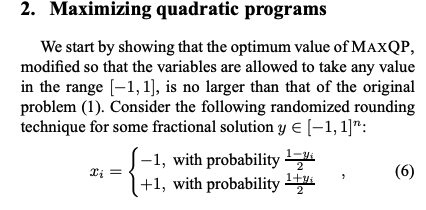

In [ ]:
# np.linalg.cholesky(Z.value)
#L, _, S = np.linalg.svd(Z_star)

#L = np.linalg.cholesky(Z_star)
L = np.linalg.cholesky(Z_star + 1e-5*np.eye(d+1))

In [ ]:
# T
T = 2 * np.sqrt(np.log(d))

# 
x_starList, f_starList = [], []
for k in range(100):
    x_star = []
    # geometric rounding
    for i in range(L.shape[0]):
        r = np.random.multivariate_normal(mean=np.zeros_like(L[0]), cov=0.01*np.eye(d+1))

        z_i = r @ L[:,i] / T

        if(abs(z_i) > 1):
            y_i = z_i / abs(z_i)
        else:
            y_i = z_i

        if(np.random.binomial(n=1,p=(1-y_i)/2.)==1):
            x_star.append(-1)
        else:
            x_star.append(1)

    # x_i in {-1,+1}
    x_star = np.asarray(x_star)

    # back-transform to {0, 1}
    x_star = (1+x_star) / 2.
    
    # clip one entry (last?)
    x_star = x_star[1:]
    
    # append lists
    x_starList.append(x_star)
    f_starList.append(g(x_star, g_dict=gD))

In [ ]:
# get global minimum
def getXStar(d:int, g_dict: dict, g:Iterable):
    '''
    Brute-force computation of global maximum given
    d : input dimension (length of binary vector)
    g_dict: 
    '''
    
    # all input combinations
    xAll = np.array(list(product([0, 1], repeat=d)))
    
    # loop
    f_opt, x_opt = -np.inf, None
    for xRow in xAll:
        f_val = g(xRow, gD)
        if(f_val > f_opt):
            f_opt = f_val
            x_opt = xRow
    
    return f_opt, x_opt

# get global minimum
def getXList(d:int, g_dict: dict, g:Iterable):
    '''
    Brute-force computation of global maximum given
    d : input dimension (length of binary vector)
    g_dict: 
    '''
    
    # all input combinations
    xAll = np.array(list(product([0, 1], repeat=d)))
    
    # loop
    f_list, x_opt = [], []
    for xRow in xAll:
        f_list.append(g(xRow, gD))
    
    return f_list

# get global minimum
def getXIndex(x:np.array, g_dict:dict, g:Callable):
    '''
    Brute-force computation of global maximum given
    d : input dimension (length of binary vector)
    g_dict: 
    '''
    
    # all input combinations
    xAll = np.array(list(product([0, 1], repeat=d)))
    
    # compute func values, sort
    fAll = getXList(d, g_dict, g)
    ind = range(len(fAll))
    
    sortMap = {k:v for k,v in zip([x for _, x in sorted(zip(fAll, ind))], range(len(fAll)))}
    
    return sortMap[np.where((xAll==x).all(axis=1))[0][0]]

In [ ]:
# get opt
f_opt, x_opt = getXStar(d, gD, g)

f_list = getXList(d, gD, g)

# x index
x_ind = [getXIndex(x, gD, g) for x in x_starList]
f_l   = [g(x, gD) for x in x_starList]

# given BOCS implementation
# obj_vect.shape, model_vect.shape

x_ind2 = [getXIndex(model_vect[:,i], gD, g) for i in range(len(model_vect))]
f_l2   = [g(model_vect[:,i], gD) for i in range(len(model_vect))]

# plot all
plt.plot(sorted(f_list))

plt.scatter(x=x_ind, y=f_l, marker='x', c='red')
plt.scatter(x=x_ind2, y=f_l2, marker='x', c='green')

## (4.) BOCS Agorithm

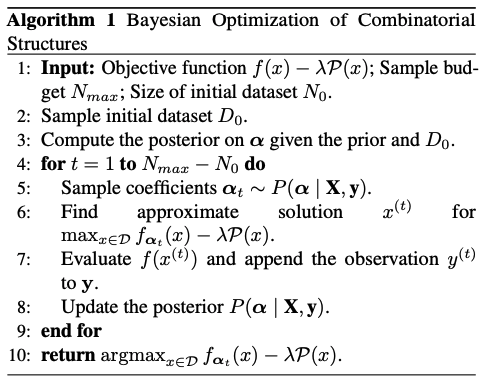

## Strategy Pattern

In [24]:
class Oracle:
    def __init__(self, fun, sigma_2:float=0.0, N_total:int=100_000, seed:int=0):
        assert isinstance(fun, Callable), "Input `f` must be a callable function."
        assert isinstance(sigma_2, float) and sigma_2>=0, "Input `sigma_2` must be a non-negative float."
        assert isinstance(seed, int), "Input `seed` must be an integer."
        
        self.fun = fun
        self.sigma_2 = sigma_2
        self.seed = seed
        self.N_total = N_total
        self.N_current = 0
        
        np.random.seed(self.seed)
        
    def __expandX__(self, x:np.array) -> np.array:
        '''
        Expand original input format {1,...,d} -> {0} + {1,...,d} + {... (d over 2) ... }
        '''
        
        # transform
        if(len(x.shape)==2 and len(x)>1):
            quad_x = np.stack([x[:,pair[0]] * x[:,pair[1]] for pair in powerset(range(x.shape[1])) if len(pair)==2], axis=1)
            assert len(quad_x)==len(x) and math.comb(len(x), 2), "Inconsistent dimension for the resulting design matrix of quadratic terms"
            x = np.concatenate((x, quad_x), axis=1)
        else:
            x = np.array(list(x) + [float(x[pair[0]] * x[pair[1]]) for pair in powerset(range(len(x))) if len(pair)==2])
            x = np.array([1] + list(x), dtype=float)
        
        return x
    
    def f(self, x:np.array, noiseFlag:bool=True):
        '''
        Returns (noisy) function value of function f
        '''
    
        # expand raw input
        #x = self.__expandX__(x)
        
        if(len(x.shape)==2 and len(x)>1):
            assert self.N_current + len(x) <= self.N_total, f"Limit of `N_total`={self.N_total} will be exceeded as {self.N_current} calls where made and this request requires another {len(x)} function calls."
            self.N_current += len(x)
            if(noiseFlag):
                return np.array([self.fun(x_) for x_ in x]) + np.random.normal(loc=0, scale=np.sqrt(self.sigma_2), size=len(x))
            else:
                return np.array([self.fun(x_) for x_ in x])
        else:
            assert self.N_current + 1 <= self.N_total, f"Limit of `N_total`={self.N_total} will be exceeded as {self.N_current} calls where made and this request requires another {len(X)} function calls."
            self.N_current += 1
            if(noiseFlag):
                return self.fun(x)+float(np.random.normal(loc=0, scale=np.sqrt(self.sigma_2), size=1))
            return self.fun(x)
        
class SparseBayesReg:

    d_MAX = 20
    
    def __init__(self, N_total:int, seed:int, burnin:int, thinning:int):

        assert isinstance(seed, int), "`seed` must be an integer."
        assert isinstance(burnin, int) and burnin>=0, "`burnin` must be a non-negative integer."
        assert isinstance(thinning, int) and thinning>=1, "`thinning` must be an positive integer."
        
        # - assignment
        self.N_total = N_total
        self.seed = seed
        self.burnin = burnin
        self.thinning = thinning
        
    def setXy(self, X:np.array, y:np.array) -> None:
        '''
        Setup of design matrix X (standardized, incl. leading 1-column and quadratic terms) and target vector y (transalted to E[y]=0)
        '''
        assert sum(X[:,0])!=len(X), "Provide the design matrix X without adding a leading 1-column (for intercept)"
        
        self.d = X.shape[1]
        self.p = 1 + self.d + math.comb(self.d, 2)
        
        assert isinstance(self.d, int) and 0<self.d<=self.d_MAX, f"The inferred dimension `d`={self.d} should be smaller than {self.d_MAX}"
        
        self.__expandX__(X)
        self.__standardizeX__()
        self.__standardizeX__()
        self.__interceptColumnX__()

        self.__translateY__(y)
    
    def __expandX__(self, X:np.array) -> None:
        '''
        Given a (binary) design matrix X, it appends pairwise products of columns and appends to the design matrix X;
        *excluding* the leading intercept column of 1's
        '''
        
        # quadratic terms
        quad_X = np.stack([X[:,pair[0]] * X[:,pair[1]] for pair in powerset(range(X.shape[1])) if len(pair)==2], axis=1)

        assert len(quad_X)==len(X) and math.comb(len(X), 2), "Inconsistent dimension for the resulting design matrix of quadratic terms"

        self.X = np.concatenate((X, quad_X), axis=1)

    def __standardizeX__(self) -> None:
        '''
        Standardizes (translates & rescales) the columns of the design matrix (input matrix) 
        '''

        X = self.X
        assert X.shape[1]==self.p-1, "The given design matrix includes a leading 1-column; unclear if it is a legitimiate (coincidental) feature or leading 1 column was already incldued"

        X_mu, X_sigma = X.mean(axis=0), X.std(axis=0)
        X_new = (X - X_mu) /  X_sigma

        self.X_mu = X_mu
        self.X_sigma = X_sigma #np.sqrt(len(X)) * X_sigma  # corrected for sqrt(n)
        self.X = X_new
        
    def __interceptColumnX__(self) -> np.array:
        '''
        Adds a leading vector of 1s to the binary matrix X (of 1st and 2nd order interactions)
        '''
        
        X = self.X
        X = np.concatenate((np.ones_like(X[:,0]).reshape(-1,1), X), axis=1)

        assert X.shape[1]==self.p, "Inconsistent number of columns after adding leading 1-col"

        self.X = X

    def __translateY__(self, y:np.array) -> None:
        '''
        Translation of the target vector y such that priori condition E[y]=0 is satisfied.
        (No rescaling to unit variance is applied, though.)
        '''
        X = self.X

        assert len(X) == len(y), "Length of target vector y does not coincide with design matrix X"

        # Standardize y's
        y_mu = np.mean(y)
        y_new = y - y_mu
        
        self.y_mu = y_mu
        self.y = y_new
        
    def add(self, x_new:np.array, y_new:float, fitFlag:bool=True) -> None:
        '''
        Appends new datapoint to X,y
        '''

        assert len(x_new.shape)==1 and len(x_new)==self.d, f"Input has dimension {x_new.shape} but ({self.d},) was expected."

        # X : expand, standardize, append leading 1
        x_new_exp = np.array(list(x_new) + [float(x_new[pair[0]] * x_new[pair[1]]) for pair in powerset(range(len(x_new))) if len(pair)==2])
        x_new_exp = (x_new_exp - self.X_mu) / self.X_sigma
        
        x_new_exp = np.array([1] + list(x_new_exp), dtype=float)
        self.X = np.append(arr=self.X, values=x_new_exp.reshape(1,-1), axis=0)

        # de-bias
        self.y = np.append(arr=self.y, values=(y_new - self.y_mu))
        
        # re-fit
        if(fitFlag):
            self.__fit__()
    
    def __mvg__(self, Phi, alpha, D):
        '''
        Sample multivariate Gaussian (independent of d) from NumPy
        Not used Rue (2001) or et. al. (2015) approaches on fast sampling mvg
        N(mean = S@Phi.T@y, cov = inv(Phi'Phi + inv(D))
        '''
        #assert len(Phi.shape)==2 and Phi.shape[0]==Phi.shape[1], "`Phi` must be a quadratic matrix."
        assert len(D.shape)==2 and D.shape[0]==D.shape[1], "`D` must be a quadratic matrix."
        
        S = np.linalg.inv(Phi.T @ Phi + np.linalg.inv(D))
        x = np.random.multivariate_normal(mean=((S @ Phi.T) @ y), cov=S, size=1)
        
        return x
    
    def sampleAlpha(self) -> np.array:
        '''
        Samples posterior  ~ P( |X,y) from (most current) posterior distribution
        '''
        alpha_post = np.random.multivariate_normal(mean = self.alpha_mu,
                                                   cov  = self.alpha_cov,
                                                   size = 1).reshape(-1)
        
        return alpha_post
    
    def __fit__(self) -> None:
        '''
        Core of fitting procedure (on self.X, self.y)
        '''
        
        # D0
        self.n = len(self.X)
        
        # setup values
        alphas_out = np.zeros((self.p, 1))
        s2_out     = np.zeros((1, 1))
        t2_out     = np.zeros((1, 1))
        l2_out     = np.zeros((self.p, 1))

        # sample priors
        betas   = halfcauchy.rvs(size=self.p) 
        tau_2   = halfcauchy.rvs(size=1)                            
        nu      = np.ones(self.p) # ?
 
        sigma_2, xi = 1.0, 1.0
        
        # Gibbs sampler
        for k in range(self.N_total):
            #print('k=')
            # std. deviation
            sigma = np.sqrt(sigma_2)

            # alphas
            # - Sigma_star
            Sigma_star = tau_2 * np.diag(betas**2) # Sigma_star
            Sigma_star_inv = np.linalg.inv(Sigma_star)
            # - A
            A     = (self.X.T @ self.X) + Sigma_star_inv
            A_inv = np.linalg.inv(A)
            
            # - update posterior mean, cov
            self.alpha_mu  = A_inv @ self.X.T @ self.y
            self.alpha_cov = sigma_2 * A_inv
            # - sample alpha
            alphas = self.sampleAlpha()
            
            # sigma_2
            sigma_2 = invgamma.rvs(0.5*(self.n+self.p), scale=0.5*(np.linalg.norm((self.y - self.X @ alphas), 2)**2 + (alphas.T @ Sigma_star_inv @ alphas)))

            
            # - betas
            betas_2 = invgamma.rvs(np.ones(self.p), scale=(1. / nu) + (alphas**2)/(2 * sigma_2 * tau_2))
            betas = np.sqrt(betas_2)

            # - tau_2
            tau_2 = invgamma.rvs(0.5*(self.p+1), scale=1.0 / xi + (1. / (2. * sigma_2)) * sum(alphas**2 / betas**2), size=1)

            # - nu
            nu = invgamma.rvs(np.ones(self.p), scale=1.0 + betas**(-2), size=self.p)

            # - xi
            xi = invgamma.rvs(1.0, scale=1.0 + 1.0 / tau_2, size=1)
            
            # store samples
            if k > self.burnin:
                # - append
                if(k%self.thinning==0):
                    alphas_out = np.append(arr=alphas_out, values=alphas.reshape(-1,1), axis=1)
                    s2_out = np.append(s2_out, sigma_2)
                    t2_out = np.append(t2_out, tau_2)
                    l2_out = np.append(arr=l2_out, values=betas.reshape(-1,1), axis=1)

        # Clip 1st value
        self.alphas = alphas_out[:,1:]
        self.s2 = s2_out[1:]
        self.t2 = t2_out[1:]
        self.l2 = l2_out[1:]
        
    def getAlphas(self) -> np.array:
        '''
        Returns current array of alpha posterior samples
        '''
        return self.alphas
    
    def fit(self, X:np.array, y:np.array) -> None:
        '''
        Fitting the (initial) model on the data D0={X0,y0}
        '''
        assert len(X.shape)==2 and len(y.shape)==1, "Design matrix X and target vector y."
        assert X.shape[0]==len(y), f"Dimension of design matrix X and target vector y do not coincide: X.shape[1]={X.shape[1]}!={len(y)}=len(y)"
        assert len(X) < self.N_total, f"Implied `N_init`=len(X)={len(X)} exceeds `N_total`={self.N_total}."
        
        # setup
        self.setXy(X, y)
        
        # fitting
        self.__fit__()
        
        

class SDP:
    penOrdList = [1, 2]
    optModes = ['min', 'max']
    d_MAX = 20
    
    def __init__(self, alpha:np.array, lambd:float=0.1, pen_ord:int=2, mode:str='min') -> List[np.array]:
        
        assert isinstance(mode, str), "Input `mode` must be a str either `min` or `max`."
        mode = mode.lower()
        assert mode in self.optModes, "Input `mode` is str. In addition, it must be a str either `min` or `max`."
        assert isinstance(lambd, float) and lambd >=0, "lambda (regularization parameter) must be non-negative scalar."
        assert pen_ord in self.penOrdList, "Only l=1 or l=2 supported for `pen_ord`"
        
        self.mode = mode
        self.lambd = lambd
        self.pen_ord = pen_ord
        self.alpha = alpha
        
        # infer d(imension)
        self.p = len(self.alpha)
        dDict = {1+dLoc+math.comb(dLoc,2) : dLoc for dLoc in range(1,self.d_MAX+1)}
        if(self.p in dDict.keys()):
            self.d = dDict[self.p]
        else:
            assert False, f'Length of `alpha` is not a 1+d+binom(d,2) for any 1,2,...,{self.d_MAX}'
        assert isinstance(self.d, int), "Dimension `d` must be non-negative integer."
        
        #print('self...d: ', self.d)
        
        # extract 1st/2nd order terms
        b = self.alpha[1:1 + self.d]  # 1st
        a = self.alpha[1 + self.d:]   # 2nd

        # get indices for quadratic terms
        idx_prod = np.array(list(combinations(np.arange(self.d), 2)))
        d_idx = idx_prod.shape[0]

        # check number of coefficients
        if len(a)!=d_idx:
            assert False, 'Number of Coefficients does not match indices!'

        # xAx-term
        A = np.zeros((self.d, self.d))
        for i in range(d_idx):
            A[idx_prod[i,0], idx_prod[i,1]] = 0.5 * a[i]
        A += A.T

        # bx-term
        bt = 0.5 * (b + A @ np.ones(self.d)).reshape((-1, 1))
        bt = bt.reshape((self.d, 1))
        At = np.vstack((np.append(0.25*A, 0.25*bt, axis=1), np.append(bt.T, 2.)))
        
        self.A  = A
        self.b  = b
        self.At = At
        self.bt = bt
        
    def run(self) -> np.array:
        '''
        Runs the BQP-relaxation, SDP-optimization, and extracts candidate x via geometric rounding
        '''
        self.solve()
        self.decompose()
        return self.geometricRounding()
        
        
    def solve(self, ) -> None:
        '''Solve SDP'''
        # SDP relaxation
        Xvar = cp.Variable((self.d+1, self.d+1), PSD=True)
        
        # - objective function
        if(self.mode=='min'):
            f0 = cp.Minimize(cp.trace((self.At @ Xvar)))
        else:
            f0 = cp.Maximize(cp.trace((self.At @ Xvar)))
        
        # - constraints
        constraints = [cp.diag(Xvar) == np.ones(self.d+1)]
        prob = cp.Problem(f0, constraints)
        prob.solve()
        
        self.Xvar = Xvar
        
        #print('Xvar.shape: ', Xvar.shape)
        
    def decompose(self) -> None:
        '''
        Wrapper for stable Cholesky decomposition
        '''
        self.L = self.__stableCholesky__(eTol=1E-12)
    
    def __stableCholesky__(self, eTol:float=1E-10) -> np.array:
        '''
        Performs numerically stable Cholesky decomposition (by adding regularity to the matrix until PSD). 
        '''
        try:
            return np.linalg.cholesky(self.Xvar.value + eTol*np.eye(self.Xvar.value.shape[0]))
        except Exception as e:
            if(isinstance(e, np.linalg.LinAlgError)):
                return self.__stableCholesky__(10*eTol)
            else:
                pass
    
    def geometricRounding(self, k_rounds:int=100) -> np.array:
        '''
        Random geometric round and conversion to original space
        - k_rounds: number of iterations
        '''
        x_cand  = np.zeros((self.d, k_rounds))
        f_star  = np.zeros(k_rounds)

        for j in range(k_rounds):
            # rnd cutting plane vector (U on Sn) 
            r = np.random.randn(self.d+1)
            r /= np.linalg.norm(r, ord=2)
            
            # rnd hyperplane
            y_star = np.sign(self.L.T @ r)

            # convert solution to original domain and assign to output vector
            x_cand[:,j] = 0.5 * (1.0 + y_star[:self.d])
            f_star[j] = (x_cand[:,j].T @ self.A @ x_cand[:,j]) + (self.b @  x_cand[:,j])

            # Find optimal rounded solution
            if(self.mode=='min'):
                f_argopt = np.argmin(f_star)
            else:
                f_argopt = np.argmax(f_star)
            x_0      = x_cand[:,f_argopt]
            f_0      = f_star[f_argopt]

        return (x_0, f_0)
        
        
        
        

In [31]:
# Frequentist Version
# - - - - - - - - - - -
d = 5
n = 30
X = np.random.binomial(n=1,p=0.5, size=n*d).reshape((n,d))

# Oracle
orc1 = Oracle(fun= lambda x: (0.5 + x.mean() - x.mean()**2 + x.mean()**3).sum(), sigma_2=1.0, N_total=100_000_000)
y = orc1.f(X)

# Bayesian Veriision
# - stat model
BayReg = SparseBayesReg(N_total=n+100, seed=12, burnin=10, thinning=5)
BayReg.setXy(X,y)
BayReg.fit(X,y)
print('\nBayesian:\n', BayReg.getAlphas().mean(axis=1).round(3))

# 
f_GT_min = [10]
for i in range(140):
    # - sample alpha
    alpha_t = BayReg.sampleAlpha()
    
    # - new SDP
    sdp1 = SDP(alpha=alpha_t, lambd=0.5, pen_ord=2, mode='min')
    x_new, y_new_hat = sdp1.run()
    
    # - add
    BayReg.add(x_new, orc1.f(x_new))
    f_GT_min.append(min(orc1.f(x_new, noiseFlag=False), min(f_GT_min)))




Bayesian:
 [ 0.001 -0.021 -0.029  0.003  0.013  0.042 -0.029  0.01  -0.003 -0.018
  0.009 -0.011 -0.008  0.028  0.012 -0.004]


In [32]:
f_GT_min

[10,
 0.9560000000000001,
 0.9560000000000001,
 0.9560000000000001,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.6679999999999999,
 0.66799

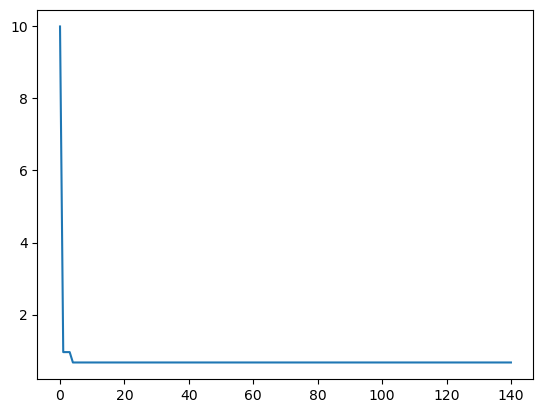

In [33]:
plt.plot(f_GT_min)

In [ ]:
alpha_t.shape[0] - (1 + 8 + math.comb(8,2))

In [ ]:
sdp1 = SDP(alpha=alpha_t, lambd=0.5, pen_ord=2, mode='min')
x_new, y_new_hat = sdp1.run()

x_new, y_new_hat, orc1.f(x_new, False)